<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/10%EC%A3%BC%EC%B0%A8/cnn%2Blstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# List the contents of the extracted directory to identify the correct path
extracted_path = "/content/human_activity_recognition"
for root, dirs, files in os.walk(extracted_path):
    print(root)
    print(dirs)
    print(files)
    print("-" * 20)

In [ ]:
!pip install tensorflow

In [ ]:
!unzip "/content/drive/MyDrive/UCI HAR Dataset.zip" -d /content/human_activity_recognition

Archive:  /content/drive/MyDrive/UCI HAR Dataset.zip
   creating: /content/human_activity_recognition/UCI HAR Dataset/
  inflating: /content/human_activity_recognition/UCI HAR Dataset/.DS_Store  
   creating: /content/human_activity_recognition/__MACOSX/
   creating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: /content/human_activity_recognition/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: /content/human_activity_recognition/UCI HAR Dataset/features.txt  
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: /content/human_activity_recognition/UCI HAR Dataset/features_info.txt  
  inflating: /content/human_activity_recognition/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: /content/human_activity_recognit

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/human_activity_recognition/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/human_activity_recognition/UCI HAR Dataset/')

    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    # one-hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print("Before scaling:", trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)

    # ===========================
    # 📏 StandardScaler 적용 부분
    # ===========================
    scaler = StandardScaler()

    # reshape to (samples*timesteps, features)
    n_samples_train, n_timesteps, n_features = trainX.shape
    n_samples_test = testX.shape[0]

    trainX_reshaped = trainX.reshape(-1, n_features)
    testX_reshaped = testX.reshape(-1, n_features)

    # fit scaler on training data only
    scaler.fit(trainX_reshaped)

    # transform both train and test
    trainX_scaled = scaler.transform(trainX_reshaped).reshape(n_samples_train, n_timesteps, n_features)
    testX_scaled = scaler.transform(testX_reshaped).reshape(n_samples_test, n_timesteps, n_features)

    print("After scaling:", trainX_scaled.shape, testX_scaled.shape)
    # ===========================

    return trainX_scaled, trainy, trainy_one_hot, testX_scaled, testy, testy_one_hot


# 데이터 불러오기
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train, X_val, y_train_one_hot_split, y_val_one_hot_split = train_test_split(
    trainX, trainy_one_hot, test_size=0.2, random_state=100
)

# Keep the original trainy and testy for evaluation purposes
# y_train and y_val are not needed for model training with one-hot encoded labels

print("✅ 데이터셋 준비 완료")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", testX.shape)

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2732011783.py:10: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')


Before scaling: (7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
After scaling: (7352, 128, 9) (2947, 128, 9)
✅ 데이터셋 준비 완료
Train: (5881, 128, 9) Val: (1471, 128, 9) Test: (2947, 128, 9)


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# 기본 차원 정의 (기존 변수 그대로 사용)
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train_one_hot_split.shape[1]

# 입력층
inputs = Input(shape=(n_timesteps, n_features))

# --- CNN 부분 ---
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

# --- LSTM 부분 ---
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=True)(x)

# --- 시퀀스 전체의 평균 특징 추출 ---
x = GlobalAveragePooling1D()(x)

# --- 완전연결층 ---
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# --- 출력층 ---
outputs = Dense(n_outputs, activation='softmax')(x)

# --- 모델 정의 및 컴파일 ---
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_history = model.fit(
    x=X_train, # Corrected to use a single input tensor
    y=y_train_one_hot_split,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot_split) # Corrected validation data format
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.6580 - loss: 0.8482 - val_accuracy: 0.8756 - val_loss: 0.3368
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9373 - loss: 0.1706 - val_accuracy: 0.9449 - val_loss: 0.1329
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9526 - loss: 0.1126 - val_accuracy: 0.9062 - val_loss: 0.2504
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9508 - loss: 0.1278 - val_accuracy: 0.9334 - val_loss: 0.1294
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9540 - loss: 0.1029 - val_accuracy: 0.9470 - val_loss: 0.1359
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.9523 - loss: 0.1256 - val_accuracy: 0.9531 - val_loss: 0.1300
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - accuracy: 0.9538 - loss: 0.1159 - val_accuracy: 0.9490 - val_loss: 0.1188
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9551 - loss: 0.1133

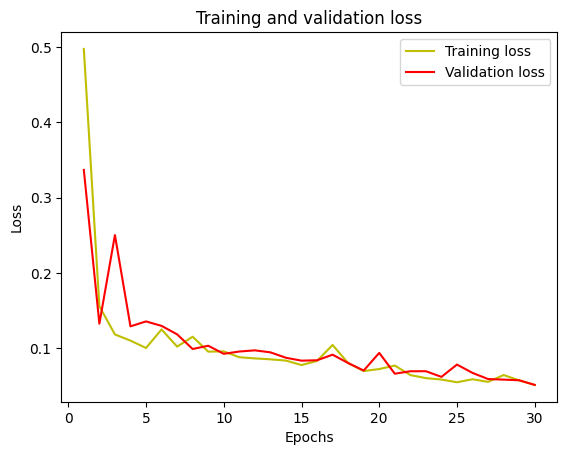

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


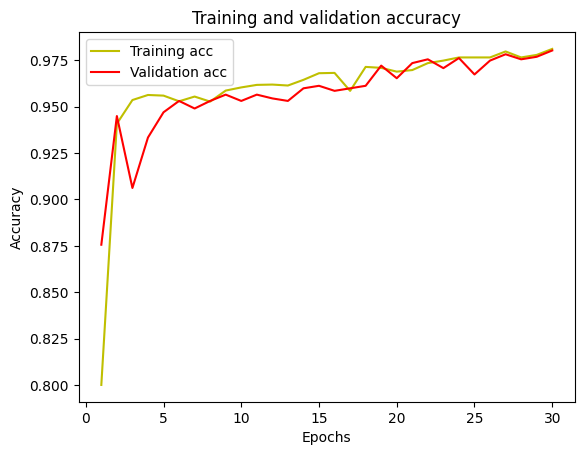

In [ ]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
[[496   0   0   0   0   0]
 [  0 447  23   1   0   0]
 [  0  18 402   0   0   0]
 [  0   1   3 398  87   2]
 [  1   1   0  46 484   0]
 [  0   0   0   0   0 537]]
0.9379029521547336
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       0.96      0.95      0.95       471
           2       0.94      0.96      0.95       420
           3       0.89      0.81      0.85       491
           4       0.85      0.91      0.88       532
           5       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

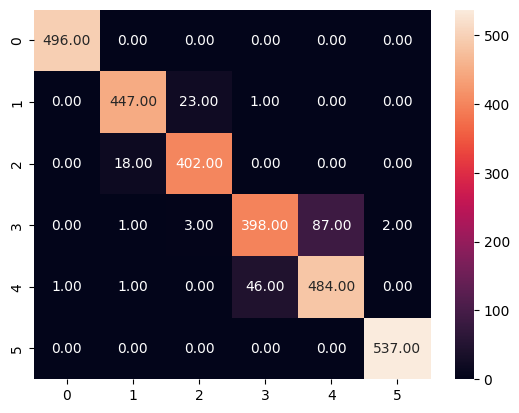

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=model.predict(testX) # Corrected to use a single input tensor
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')